In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
import skimage
import numpy as np
import matplotlib.pyplot as plt
import lime
from lime import lime_image
import shap, json

In [ ]:
# get imagenet class names
url = "https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]

In [ ]:
# load the ResNet model
model = ResNet50(weights="imagenet")

In [ ]:
# helper functions
def load_img(path, shape):
    img = image.load_img(path, target_size=shape)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

def predict_class(X):
    tmp = X.copy()
    preprocess_input(tmp)
    return model(tmp)

('n02123597', 'Siamese_cat', 0.22126625)
('n02120079', 'Arctic_fox', 0.13802283)
('n02124075', 'Egyptian_cat', 0.08029285)
('n02441942', 'weasel', 0.071751036)
('n02442845', 'mink', 0.06411552)


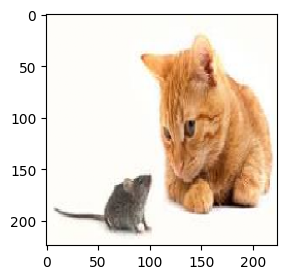

In [ ]:
# load a cat and mouse image
img = load_img('img.jpeg', (224, 224))

# make prediction
preds = predict_class(img)
plt.figure(figsize=(3,3))
plt.imshow(img[0]/255)
for x in decode_predictions(preds)[0]:
    print(x)

In [31]:
# instantiate lime image explainer and get the explaination 
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(img[0], predict_class, top_labels=5, hide_color=0, num_samples=1000)



100%|██████████| 1000/1000 [00:47<00:00, 21.03it/s]


In [ ]:
# plot interpretation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=100, hide_rest=False)


The pixels corresponding to the cat should be marked

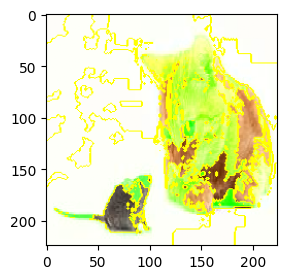

In [36]:
plt.figure(figsize=(3,3))
plt.imshow(skimage.segmentation.mark_boundaries(temp / 255, mask))

In [38]:
explanation.top_labels[0]

284

In [67]:
def predict_class2(X):
    tmp = X.copy()
    preprocess_input(tmp)
    return model(tmp)

# Get images from the ImageNet dataset
X, y = shap.datasets.imagenet50()

# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(predict_class2, masker, output_names=class_names)



The pixels corresponding to predicted class has high shap values.
The images is ordered by the class probabilities.

https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Explain%20ResNet50%20using%20the%20Partition%20explainer.html

PartitionExplainer explainer: 3it [00:36, 18.50s/it]               


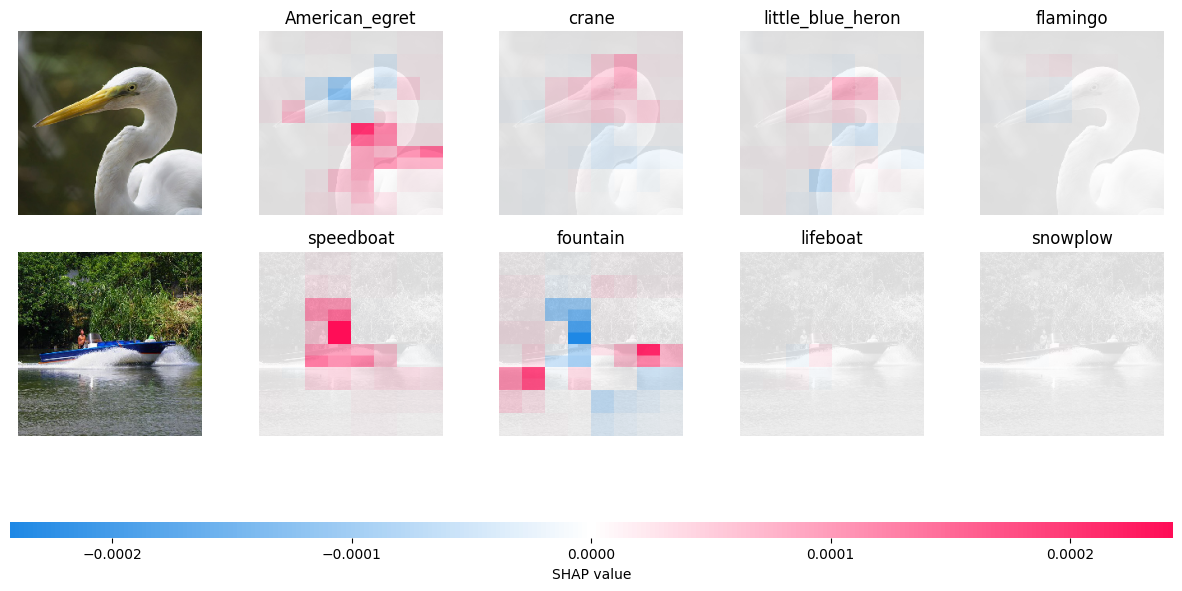

In [68]:
# get the shap values 
shap_values = explainer(X[1:3], max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])
shap_values.data = shap_values.data/255
shap.image_plot(shap_values)